In [1]:
import pandas as pd

df_text = pd.read_csv('data/tweets_corregidos.csv')

In [2]:
!curl -L -o glove6b100dtxt.zip https://www.kaggle.com/api/v1/datasets/download/danielwillgeorge/glove6b100dtxt
!unzip glove6b100dtxt.zip
!rm glove6b100dtxt.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
100  131M  100  131M    0     0  2258k      0  0:00:59  0:00:59 --:--:-- 2430k
Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [3]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10124 entries, 0 to 10123
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Twitter  10124 non-null  object
 1   NPS      10124 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 158.3+ KB


In [4]:
df_text.head()

,Twitter,NPS
0,ok i am loving this,2
1,i hate the mobile app it doesnt work very well,0
2,ok i am loving this,2
3,appreciated you attention in the contact center,2
4,appreciate the conversations and actions broug...,2


In [5]:
df_text['NPS'].value_counts()

NPS
2    5926
1    3083
0    1115
Name: count, dtype: int64

In [6]:
import numpy as np
import re
import nltk
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from nltk import pos_tag, ngrams
from tqdm import tqdm
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer


# --- NLTK ---
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
try:
    nltk.download('averaged_perceptron_tagger_eng')
except:
    nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-záéíóúüñ ]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize_and_lemmatize(series):
    from nltk import pos_tag
    all_tokens = []
    for text in tqdm(series, desc="Tokenizing & Lemmatizing"):
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        pos_tags = pos_tag(tokens, lang='eng')
        lemmas = [lemmatizer.lemmatize(t, get_wordnet_pos(pos)) for t, pos in pos_tags]
        all_tokens.append(lemmas)
    return all_tokens


# --- Preparar texto ---
df_cleaned = df_text.dropna()
df_cleaned['Twitter'] = df_text['Twitter'].apply(clean_text)

# Ejemplo: suponiendo que df_cleaned tiene la columna NPS como target
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df_cleaned['Twitter'], df_cleaned['NPS'], test_size=0.2, random_state=42
)

# --- Cargar GloVe ---
glove_path = 'glove.6B.100d.txt'
glove = {}
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove[word] = vector


# --- Función para obtener embeddings (con bigramas/trigramas) ---
def get_embeddings(train_col, test_col, glove, use_bigrams=True, use_trigrams=True):

    # --- Tokenización, lematización y generación de n-grams ---
    def process_series(series):
        tokenized = []
        for text in tqdm(series, desc="Tokenizing + Lemmatizing + N-grams"):
            tokens = word_tokenize(text)
            tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
            pos_tags = pos_tag(tokens, lang='eng')
            lemmas = [lemmatizer.lemmatize(t, get_wordnet_pos(pos)) for t, pos in pos_tags]

            # Agregar bigramas y trigramas
            ngram_tokens = lemmas.copy()
            if use_bigrams:
                ngram_tokens.extend(['_'.join(bg) for bg in ngrams(lemmas, 2)])
            if use_trigrams:
                ngram_tokens.extend(['_'.join(tg) for tg in ngrams(lemmas, 3)])

            tokenized.append(ngram_tokens)
        return tokenized

    train_tokens = process_series(train_col)
    test_tokens  = process_series(test_col)

    # --- Word2Vec ---
    w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4)
    def avg_vector(tokens, model):
        vecs = [model.wv[w] for w in tokens if w in model.wv]
        return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)
    X_train_w2v = np.array([avg_vector(t, w2v_model) for t in train_tokens])
    X_test_w2v  = np.array([avg_vector(t, w2v_model) for t in test_tokens])

    # --- GloVe ---
    def avg_glove(tokens, glove_model):
        vecs = [glove_model[w] for w in tokens if w in glove_model]
        return np.mean(vecs, axis=0) if vecs else np.zeros(100)
    X_train_glove = np.array([avg_glove(t, glove) for t in train_tokens])
    X_test_glove  = np.array([avg_glove(t, glove) for t in test_tokens])

    # --- SBERT ---
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
    X_train_sbert = sbert_model.encode(train_col.tolist(), batch_size=32, show_progress_bar=True)
    X_test_sbert  = sbert_model.encode(test_col.tolist(), batch_size=32, show_progress_bar=True)

    return X_train_w2v, X_test_w2v, X_train_glove, X_test_glove, X_train_sbert, X_test_sbert


X_train_w2v, X_test_w2v, X_train_glove, X_test_glove, X_train_sbert, X_test_sbert = \
    get_embeddings(X_train_text, X_test_text, glove)

print("✅ Embeddings generados:")
print("Word2Vec:", X_train_w2v.shape)
print("GloVe:", X_train_glove.shape)
print("SBERT:", X_train_sbert.shape)


/home/ariel/Escritorio/proyectos/RoboAdvisoryGenAI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-30 22:25:13.494181: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to /home/ariel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ariel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ariel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package av

✅ Embeddings generados:
Word2Vec: (8099, 100)
GloVe: (8099, 100)
SBERT: (8099, 384)


In [7]:
import gc
gc.collect()

1988

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.utils import to_categorical

# --- Convertir etiquetas a one-hot ---
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat  = to_categorical(y_test, num_classes=num_classes)

def build_fixed_model(input_dim, output_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(32, activation='relu')(inputs)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(output_dim, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_model_metrics(X_train, y_train_cat, X_test, y_test_cat, name):
    input_dim = X_train.shape[1]
    output_dim = y_train_cat.shape[1]
    
    tf.keras.backend.clear_session()
    gc.collect()
    
    model = build_fixed_model(input_dim, output_dim)
    
    stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    model.fit(X_train, y_train_cat,
              validation_data=(X_test, y_test_cat),
              epochs=30,
              batch_size=64,
              callbacks=[stop_early],
              verbose=1)
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test_cat, axis=1)
    
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='weighted')
    cm  = confusion_matrix(y_true, y_pred)
    
    return model, acc, f1, cm, y_pred

model_w2v, acc_w2v, f1_w2v, cm_w2v, y_pred_w2v = train_model_metrics(
    X_train_w2v, y_train_cat, X_test_w2v, y_test_cat, "Word2Vec"
)
gc.collect()
model_glove, acc_glove, f1_glove, cm_glove, y_pred_glove = train_model_metrics(
    X_train_glove, y_train_cat, X_test_glove, y_test_cat, "GloVe"
)
gc.collect()
model_sbert, acc_sbert, f1_sbert, cm_sbert, y_pred_sbert = train_model_metrics(
    X_train_sbert, y_train_cat, X_test_sbert, y_test_cat, "SBERT"
)

print("Word2Vec -> Accuracy:", acc_w2v, "F1:", f1_w2v)
print("GloVe     -> Accuracy:", acc_glove, "F1:", f1_glove)
print("SBERT     -> Accuracy:", acc_sbert, "F1:", f1_sbert)

I0000 00:00:1764559538.321048  245967 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1541 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/30


2025-11-30 22:25:39.864892: I external/local_xla/xla/service/service.cc:163] XLA service 0x762ff8003e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-30 22:25:39.864905: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-11-30 22:25:39.907744: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-30 22:25:40.056175: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-11-30 22:25:40.149407: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


106/127 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.6276 - loss: 0.8681

I0000 00:00:1764559542.036284  339394 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-30 22:25:42.343724: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-30 22:25:42.600598: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_168', 12 bytes spill stores, 12 bytes spill loads



127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6464 - loss: 0.8334 

2025-11-30 22:25:44.906388: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-30 22:25:45.187580: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_66', 12 bytes spill stores, 12 bytes spill loads



127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7492 - loss: 0.6381 - val_accuracy: 0.8849 - val_loss: 0.3434
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8581 - loss: 0.3313 - val_accuracy: 0.8849 - val_loss: 0.2575
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8789 - loss: 0.2716 - val_accuracy: 0.8849 - val_loss: 0.2232
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8917 - loss: 0.2325 - val_accuracy: 0.8943 - val_loss: 0.1803
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9299 - loss: 0.1857 - val_accuracy: 0.9551 - val_loss: 0.1342
Epoch 6/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9602 - loss: 0.1422 - val_accuracy: 0.9911 - val_loss: 0.0984
Epoch 7/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9717 - loss: 0.1147 - val_accuracy: 0.9911 - val_loss: 0.0704
Epoch 8/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9810 - loss: 0.0906 - val_accuracy: 0.9911 - val

2025-11-30 22:26:08.202205: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-30 22:26:08.745559: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_168', 4 bytes spill stores, 4 bytes spill loads



 94/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7651 - loss: 0.8004

2025-11-30 22:26:10.299545: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-30 22:26:10.743247: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_168', 12 bytes spill stores, 12 bytes spill loads

2025-11-30 22:26:10.846726: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_168', 4 bytes spill stores, 4 bytes spill loads

2025-11-30 22:26:10.972279: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_168', 60 bytes s

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7942 - loss: 0.7202

2025-11-30 22:26:12.565790: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-30 22:26:13.026397: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_66', 12 bytes spill stores, 12 bytes spill loads

2025-11-30 22:26:13.104774: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_66', 4 bytes spill stores, 4 bytes spill loads

2025-11-30 22:26:13.326409: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_66', 60 bytes spil

127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8905 - loss: 0.4436 - val_accuracy: 0.9911 - val_loss: 0.0739
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.0562 - val_accuracy: 0.9965 - val_loss: 0.0146
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0123 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 8.6767e-04
Epoch 6/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 5.4132e-04
Epoch 7/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 2.9885e-04
Epoch 8/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0036 - val_accuracy: 

2025-11-30 22:26:20.717116: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-30 22:26:20.961069: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 4 bytes spill stores, 4 bytes spill loads

2025-11-30 22:26:21.149808: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 12 bytes spill stores, 12 bytes spill loads

2025-11-30 22:26:21.244259: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 4 bytes spill st

 1/64 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step

2025-11-30 22:26:22.001246: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 12 bytes spill stores, 12 bytes spill loads



64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Word2Vec -> Accuracy: 0.9916049382716049 F1: 0.9914731457113334
GloVe     -> Accuracy: 0.9950617283950617 F1: 0.9950203359970663
SBERT     -> Accuracy: 1.0 F1: 1.0


In [9]:
gc.collect()

1043

In [10]:
model_w2v.save("models/2/Word2Vec.keras")
model_glove.save("models/2/GLOVE.keras")
model_sbert.save("models/2/SBERT.keras")

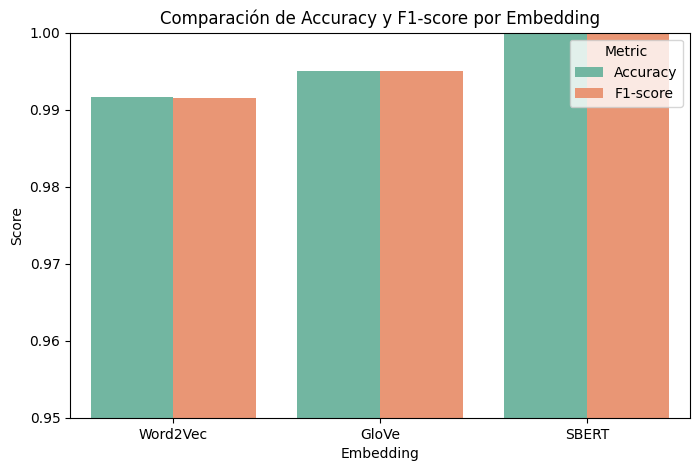

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_metrics_comparison(acc_dict, f1_dict):
    df = pd.DataFrame({
        'Embedding': list(acc_dict.keys()) * 2,
        'Metric': ['Accuracy']*len(acc_dict) + ['F1-score']*len(f1_dict),
        'Value': list(acc_dict.values()) + list(f1_dict.values())
    })

    plt.figure(figsize=(8,5))
    sns.barplot(x='Embedding', y='Value', hue='Metric', data=df, palette='Set2')
    plt.ylim(0.95,1)
    plt.title("Comparación de Accuracy y F1-score por Embedding")
    plt.ylabel("Score")
    plt.show()

# --- Usar la función con tus métricas ---
acc_dict = {'Word2Vec': acc_w2v, 'GloVe': acc_glove, 'SBERT': acc_sbert}
f1_dict  = {'Word2Vec': f1_w2v, 'GloVe': f1_glove, 'SBERT': f1_sbert}

plot_metrics_comparison(acc_dict, f1_dict)

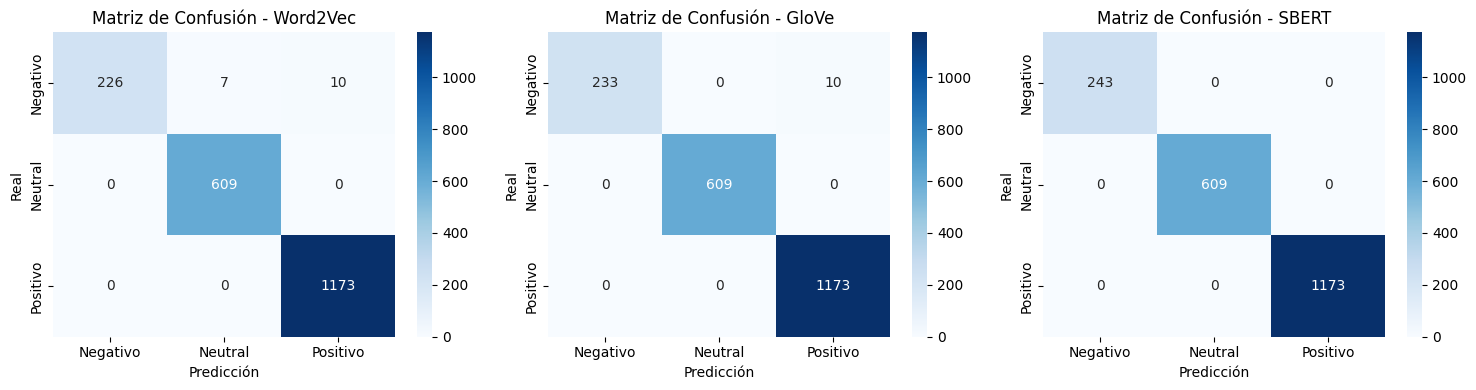

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(y_true, preds_dict, labels):
    
    n = len(preds_dict)
    plt.figure(figsize=(5*n, 4))
    
    for i, (name, y_pred) in enumerate(preds_dict.items(), 1):
        cm = confusion_matrix(y_true, y_pred)
        plt.subplot(1, n, i)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title(f"Matriz de Confusión - {name}")
        plt.xlabel("Predicción")
        plt.ylabel("Real")
    
    plt.tight_layout()
    plt.show()

# --- Ejemplo de uso ---
preds_dict = {
    'Word2Vec': y_pred_w2v,
    'GloVe': y_pred_glove,
    'SBERT': y_pred_sbert
}

# Ajusta los nombres según tu codificación
labels = ['Negativo', 'Neutral', 'Positivo']

plot_confusion_matrices(y_test, preds_dict, labels)

In [15]:
gc.collect()

14393

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


rf = RandomForestClassifier(
    n_estimators=10,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

print("🌲 Entrenando Random Forest...")
rf.fit(X_train_sbert, y_train)

# --- Predicciones ---
y_pred = rf.predict(X_test_sbert)

# --- Resultados ---
print("\n✅ Evaluación del modelo:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

🌲 Entrenando Random Forest...

✅ Evaluación del modelo:
Accuracy: 1.0

Confusion Matrix:
[[ 243    0    0]
 [   0  609    0]
 [   0    0 1173]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      1.00      1.00       609
           2       1.00      1.00      1.00      1173

    accuracy                           1.00      2025
   macro avg       1.00      1.00      1.00      2025
weighted avg       1.00      1.00      1.00      2025

